In [50]:
# Import modules
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams  
import nltk, collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marvinspurk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marvinspurk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
# Import data
df = pd.read_json("News_Category_Dataset_v3.json", orient = "records", lines = True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


## Spaltenanalyse

In [52]:
# Columnlist for analysis
column_list = []
for column in df.columns:
    column_list.append(column)

In [53]:
# Complete dataset information
length_df = len(df)
amount_attributes = len(column_list)
print('Anzahl an Datensätzen: ', length_df)
print('Anzahl an Attributen: ', amount_attributes)

Anzahl an Datensätzen:  209527
Anzahl an Attributen:  6


In [54]:
# Column overview
print('Existing columns: \n', column_list)

Existing columns: 
 ['link', 'headline', 'category', 'short_description', 'authors', 'date']


In [55]:
# Datatype per column
print('Datentyp je Attribut: \n', df.dtypes)

Datentyp je Attribut: 
 link                         object
headline                     object
category                     object
short_description            object
authors                      object
date                 datetime64[ns]
dtype: object


## Analyse der Daten für jede Spalte

In [56]:
# Unique Values per column
count_of_unique_values = {}
for column in column_list:
    valueset = set(df[column])
    valueset = {x for x in valueset if pd.notna(x)}
    count_of_unique_values[column] = len(valueset)/length_df

In [57]:
# Function to analysize the columns
def _column_values(column):

    # Pre-calculation of unique values
    count_of_unique_elements = df[column].value_counts()

    # Print of the column name and the count of the unique values
    print(column)
    print('Anzahl unique values:', count_of_unique_values[column])

    # < 0.05 / section 4
    if count_of_unique_values[column] < 0.05:
        print('Es gibt wenig verschiedene Werte (> 5%)')

        # # plot percent of values
        percent = round(count_of_unique_elements / length_df *100,2)
        fig = px.bar(percent, title = 'Anzahl Vorkommen einzelner Werte in Attribut "{}"'.format(column), labels = {'index': 'Werte', 'value': 'Prozent'})
        fig.update_layout(showlegend = False)
        fig.show()
        
    # < 0.35 / section 3
    elif count_of_unique_values[column] < 0.35:
        print('mittendrin - to do')
    

    #  < 1 / section 1 und 2 
    elif count_of_unique_values[column] < 1:
        print('idee: sich wiederholende Werte anzeigen - tbd')
            
    # == 1 / uniqueIdentifier
    elif count_of_unique_values[column] == 1:
        print('Die Werte sind den Datensätzen eindeutig zuzuordnen (unique_identifier)')

In [58]:
# Link information
_column_values('link')

link
Anzahl unique values: 0.9998043211614732
idee: sich wiederholende Werte anzeigen - tbd


In [59]:
# Headline information
_column_values('headline')

headline
Anzahl unique values: 0.9926930658101343
idee: sich wiederholende Werte anzeigen - tbd


In [60]:
# Category information
_column_values('category')

category
Anzahl unique values: 0.00020045149312499105
Es gibt wenig verschiedene Werte (> 5%)


In [61]:
# Short description information
_column_values('short_description')

short_description
Anzahl unique values: 0.8925914082671923
idee: sich wiederholende Werte anzeigen - tbd


In [62]:
# Authors information
_column_values('authors')

authors
Anzahl unique values: 0.1392135619753063
mittendrin - to do


In [63]:
# Date information
_column_values('date')

date
Anzahl unique values: 0.018565626387052742
Es gibt wenig verschiedene Werte (> 5%)


## Wortanalyse

In [64]:
# Function to classify the words
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

def remove_stopwords(tokenized_column):
    stops = set(stopwords.words("english"))
    return [word for word in tokenized_column if not word in stops]


def apply_stemming(tokenized_column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokenized_column]


def rejoin_words_from_list(tokenized_column):
    return (" ".join(tokenized_column))

In [65]:
# Preparation of the data
def preprocess_data_for_nlp(df):
    df['tokenized'] = df.apply(lambda x: tokenize(x['short_description']), axis=1)
    df['stopwords_removed'] = df.apply(
        lambda x: remove_stopwords(x['tokenized']), axis=1)
    df['porter_stemmed'] = df.apply(
        lambda x: apply_stemming(x['stopwords_removed']), axis=1)
    df['rejoined'] = df.apply(
        lambda x: rejoin_words_from_list(x['porter_stemmed']), axis=1)
    return df

In [66]:
# Performing the preparation
def prepare_dataframe(df):
    df = preprocess_data_for_nlp(df)
    return df

df = prepare_dataframe(df)

In [67]:
# The most common two word sequences
def most_common_two(df):
    text = []
    for i in df.tokenized:
        text_1 = i
        text += text_1
    esBigrams = ngrams(text, 2)
    esBigramFreq = collections.Counter(esBigrams)
    most_common_words = esBigramFreq.most_common(15)
    return most_common_words

In [68]:
most_common_words = most_common_two(df)
most_common_words

[(('of', 'the'), 18335),
 (('in', 'the'), 15125),
 (('to', 'the'), 7868),
 (('to', 'be'), 7103),
 (('on', 'the'), 6444),
 (('for', 'the'), 5707),
 (('is', 'a'), 5625),
 (('in', 'a'), 4912),
 (('at', 'the'), 4353),
 (('and', 'the'), 4286),
 (('of', 'a'), 4024),
 (('is', 'the'), 3749),
 (('with', 'the'), 3519),
 (('from', 'the'), 3391),
 (('for', 'a'), 3209)]

In [69]:
# The most common three word sequences
def most_common_three(df):
    text = []
    for i in df.tokenized:
        text_1 = i
        text += text_1
    esBigrams = ngrams(text, 3)
    esBigramFreq = collections.Counter(esBigrams)
    most_common_words = esBigramFreq.most_common(20)
    return most_common_words

In [70]:
most_common__three3 = most_common_three(df)
most_common__three3

[(('one', 'of', 'the'), 1663),
 (('a', 'lot', 'of'), 1005),
 (('on', 'Twitter', 'Facebook'), 881),
 (('to', 'check', 'out'), 870),
 (('sure', 'to', 'check'), 851),
 (('Be', 'sure', 'to'), 845),
 (('of', 'the', 'most'), 844),
 (('some', 'of', 'the'), 818),
 (('it', 'comes', 'to'), 803),
 (('the', 'United', 'States'), 798),
 (('to', 'be', 'a'), 796),
 (('Want', 'more', 'Be'), 770),
 (('more', 'Be', 'sure'), 762),
 (('Twitter', 'Facebook', 'Tumblr'), 677),
 (('in', 'the', 'world'), 644),
 (('check', 'out', 'HuffPost'), 608),
 (('out', 'HuffPost', 'Style'), 597),
 (('HuffPost', 'Style', 'on'), 585),
 (('Style', 'on', 'Twitter'), 581),
 (('is', 'one', 'of'), 559)]

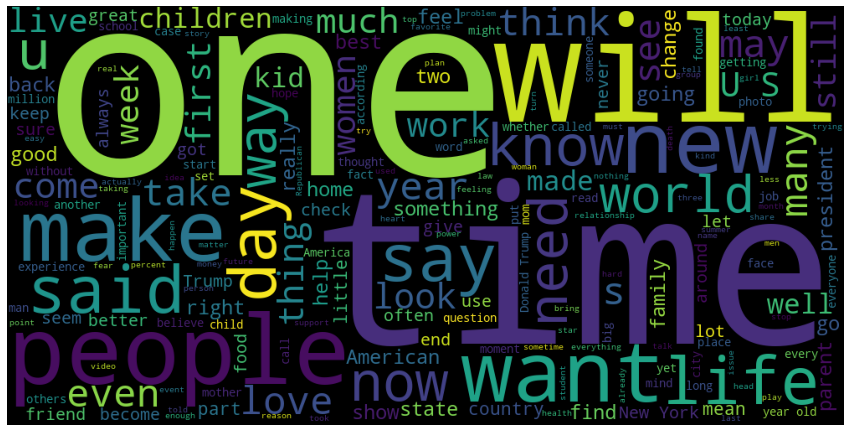

In [71]:
# Bubble of the most common words
my_list =  df.short_description
unique_string=(" ").join(my_list)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()